In [19]:
import os
import imageio
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.linalg import eigh
from sklearn.decomposition import PCA as skl_PCA
from gpflow.config import set_default_float, default_float, set_summary_fmt
import gpflow

from IPython.display import Image, display
import tensorflow as tf

IMG_DIMS = (72, 72, 4)
imshow = lambda flat: plt.imshow(flat.reshape(IMG_DIMS))

def load_faces():
    facedir = 'faces/'
    
    face_arrays = []
    dim = 72 * 72 * 4
    for f in os.listdir(facedir):
        im = imageio.imread(f'{facedir}/{f}')
        face_arrays.append(im.reshape(-1))
    return np.array(face_arrays)

Y = load_faces()
norm = (np.sum(Y, axis=0) + 1e-8)
Y_norm = Y / norm
mu_norm = np.mean(Y_norm, axis=0)

Y_centre = Y_norm - mu_norm

In [100]:
pca = skl_PCA(n_components=48)
pca2 = skl_PCA(n_components=2)


In [101]:
pca.fit(Y_centre)
pca2.fit(Y_centre)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [102]:
print(pca.components_.shape, Y.shape)

(48, 20736) (88, 20736)


In [103]:
y_hat = ((((Y_centre) @ pca.components_.T  )@ pca.components_) +mu_norm) * norm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


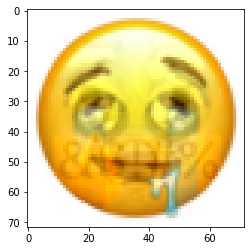

In [104]:
emoji=1
imshow(y_hat[emoji].astype(np.int32))

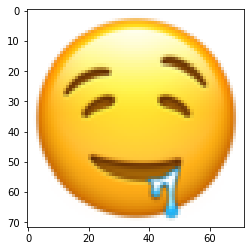

In [105]:
imshow(Y[emoji])

In [113]:
import time
now = time.time()
def gplvm(ydata, x_mean_init):
    latent_dim = x_mean_init.shape[1]

    lengthscale = tf.convert_to_tensor([1.0] * latent_dim, dtype=default_float())
    kernel1 = gpflow.kernels.RBF(lengthscale=lengthscale, ard=True)
    kernel = kernel1

    model = gpflow.models.GPLVM(ydata.astype(np.float64),
                                latent_dim = latent_dim,
                                x_data_mean=x_mean_init,
            kernel=kernel)

    model.likelihood.variance.assign(0.01)

    opt = gpflow.optimizers.Scipy()

    gpflow.utilities.print_summary(model, fmt='notebook')

    # @tf.function(autograph=False)
    def optimization_step():
        return model.neg_log_marginal_likelihood()
   
    _ = opt.minimize(optimization_step, variables=model.trainable_variables, options=dict(maxiter=300))

    gpflow.utilities.print_summary(model, fmt='notebook')
    return model

modelgp = gplvm(Y_centre, (Y_centre @ pca2.components_.T))
print(time.time() - now)

name,class,transform,trainable,shape,dtype,value
GPLVM.kernel.variance,Parameter,Softplus,True,(),float64,1.0
GPLVM.kernel.lengthscale,Parameter,Softplus,True,"(2,)",float64,[1. 1.]
GPLVM.likelihood.variance,Parameter,Softplus,True,(),float64,0.009999999776482648


name,class,transform,trainable,shape,dtype,value
GPLVM.kernel.variance,Parameter,Softplus,True,(),float64,0.0018286410614415435
GPLVM.kernel.lengthscale,Parameter,Softplus,True,"(2,)",float64,[0.39510783 0.02903236]
GPLVM.likelihood.variance,Parameter,Softplus,True,(),float64,3.6929211168307485e-06


49.45640969276428


In [114]:
x_data = modelgp.data[0].numpy()

In [138]:
x_data

array([[  -4.72045732,   -3.12201239],
       [  -4.7455717 ,   -3.14081106],
       [  -4.68145635,   -3.12971509],
       [  -4.68079131,   -3.12965015],
       [  39.20911599,   59.42865322],
       [  -4.0101003 ,   -3.50534849],
       [  -4.56092393,   -3.2164169 ],
       [  -5.08365417,   -3.66698584],
       [  -4.67837033,   -3.12938886],
       [  -4.68009903,   -3.1285298 ],
       [  76.2186985 ,  -38.82945354],
       [ -34.81838016,   -1.90334208],
       [  -3.33128831,   -2.85859214],
       [  -4.68362823,   -3.12906534],
       [   2.14380983,  -27.41875102],
       [  -4.69052876,   -3.1299799 ],
       [  -3.27373225,   -2.84428421],
       [  -4.55473011,   -3.5091888 ],
       [ 106.17272615,   44.00898474],
       [  10.67779706,  -11.00028373],
       [  -4.20771395,   -3.53598265],
       [   7.54523655,   13.32259528],
       [ -11.93552231,   -3.32120066],
       [   2.93918973,   20.2266912 ],
       [  -4.61844534,   -3.50502901],
       [  -3.46196772,   

In [154]:
ypred = (modelgp.predict_f(x_data[None, emoji])[0].numpy() + mu_norm) * norm
imshow2 = lambda x:imshow(((modelgp.predict_f(np.array([x]).astype(np.float64))[0].numpy() + mu_norm) * norm).astype(np.int64))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


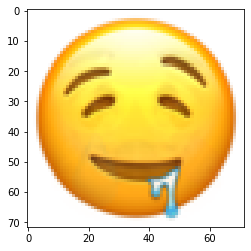

In [155]:
imshow(ypred.astype(int))

88


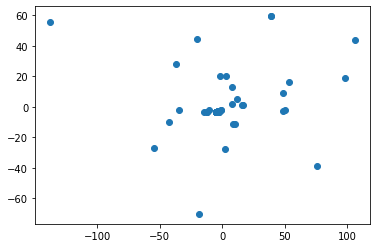

In [156]:
plt.scatter(x_data[:,0 ], x_data[:, 1])
print(len(x_data[:, 0]))

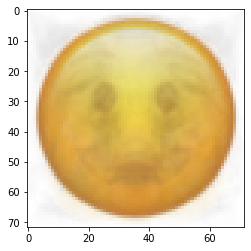

In [165]:
imshow2([  0,   10])

<IPython.core.display.Javascript object>


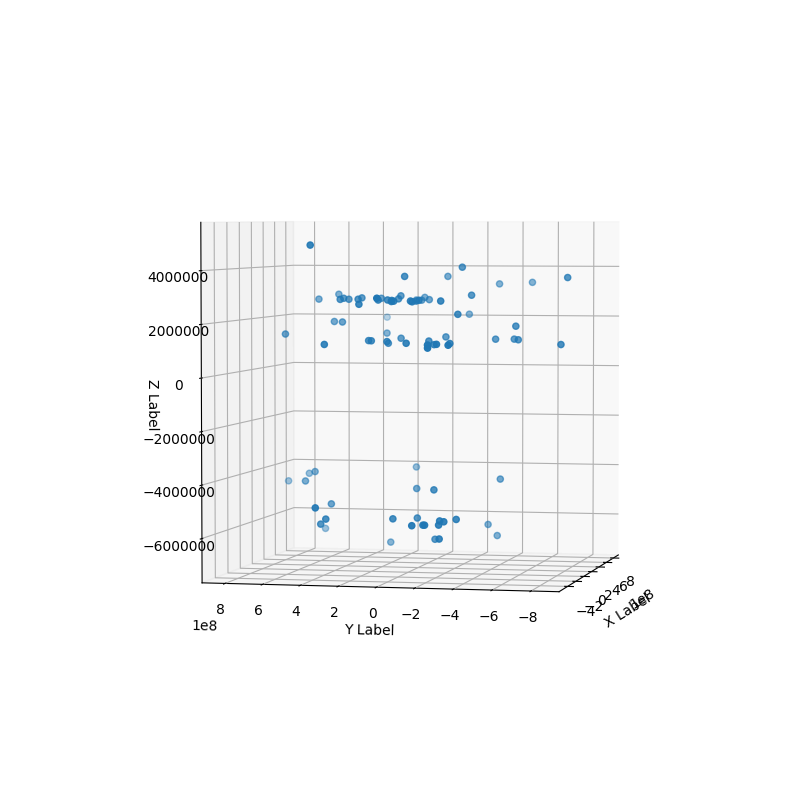

In [126]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
# for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
#     xs = randrange(n, 23, 32)
#     ys = randrange(n, 0, 100)
#     zs = randrange(n, zlow, zhigh)
ax.scatter(x_data[:, 0], x_data[:, 1], x_data[:, 2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [172]:
from gpflow.config import set_default_float, default_float, set_summary_fmt

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



def fit_gplvm(ydata, x_mean_init):
    latent_dim = x_mean_init.shape[1]
    num_inducing_points = 80
     
    x_var_init = tf.convert_to_tensor(np.ones((ydata.shape[0], latent_dim)), dtype=default_float())

    inducing_variable = tf.convert_to_tensor(np.random.permutation(x_mean_init)[:num_inducing_points], dtype=default_float())
    lengthscale = tf.convert_to_tensor([1.0] * latent_dim, dtype=default_float())
    kernel1 = gpflow.kernels.RBF(lengthscale=lengthscale, ard=True)
    kernel = kernel1

    model = gpflow.models.BayesianGPLVM(ydata.astype(np.float64),
            x_data_mean=tf.convert_to_tensor(x_mean_init),
            x_data_var=x_var_init,
            kernel=kernel,
            inducing_variable=inducing_variable)

    model.likelihood.variance.assign(0.01)

    opt = gpflow.optimizers.Scipy()

    gpflow.utilities.print_summary(model, fmt='notebook')

    # @tf.function(autograph=False)
    def optimization_step():
        return model.neg_log_marginal_likelihood()
   
    _ = opt.minimize(optimization_step, variables=model.trainable_variables, options=dict(maxiter=1000))

    gpflow.utilities.print_summary(model, fmt='notebook')
    return model
mod = fit_gplvm(Y_centre, (Y_centre @ pca2.components_.T))


name,class,transform,trainable,shape,dtype,value
BayesianGPLVM.kernel.variance,Parameter,Softplus,True,(),float64,1.0
BayesianGPLVM.kernel.lengthscale,Parameter,Softplus,True,"(2,)",float64,[1. 1.]
BayesianGPLVM.likelihood.variance,Parameter,Softplus,True,(),float64,0.009999999776482648
BayesianGPLVM.x_data_mean,Parameter,,True,"(88, 2)",float64,"[[-6.89415612e-01, -7.27713643e-02..."
BayesianGPLVM.x_data_var,Parameter,Softplus,True,"(88, 2)",float64,"[[1., 1...."
BayesianGPLVM.inducing_variable.Z,Parameter,,True,"(80, 2)",float64,"[[2.31493387e+00, -2.71789281e-01..."


name,class,transform,trainable,shape,dtype,value
BayesianGPLVM.kernel.variance,Parameter,Softplus,True,(),float64,0.0024706989303042146
BayesianGPLVM.kernel.lengthscale,Parameter,Softplus,True,"(2,)",float64,[1.96655953 0.18806829]
BayesianGPLVM.likelihood.variance,Parameter,Softplus,True,(),float64,1.1510126210067772e-05
BayesianGPLVM.x_data_mean,Parameter,,True,"(88, 2)",float64,"[[0.06862471, -0.35850799..."
BayesianGPLVM.x_data_var,Parameter,Softplus,True,"(88, 2)",float64,"[[3.24255067e-05, 3.23903511e-07..."
BayesianGPLVM.inducing_variable.Z,Parameter,,True,"(80, 2)",float64,"[[-3.05518507e-01, 3.42040275e+00..."


In [174]:
Z = mod.inducing_variable.Z

In [175]:
pred = (mod.predict_f(x_data[None, emoji])[0].numpy() + mu_norm) * norm
imshow3 = lambda x:imshow(((mod.predict_f(np.array([x]).astype(np.float64))[0].numpy() + mu_norm) * norm).astype(np.int64))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


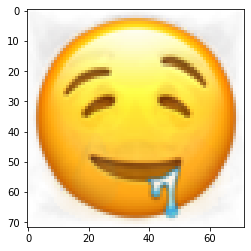

In [242]:
imshow3(Z[emoji+2])
imshow2(x_data[emoji])
imshow4 = lambda x:imshow(((modelgp.predict_f_samples(np.array([x]).astype(np.float64))[0].numpy() + mu_norm) * norm).astype(np.int64))

pred = (mod.predict_f(x_data[None, emoji])[0].numpy() + mu_norm) * norm


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


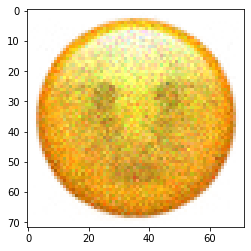

In [240]:
imshow4(x_data[emoji+8])


In [245]:
def var(x):
    return np.sum(modelgp.predict_f(np.array([x]).astype(np.float64))[1].numpy())
var(x_data[emoji+1])

0.0031255433578172287

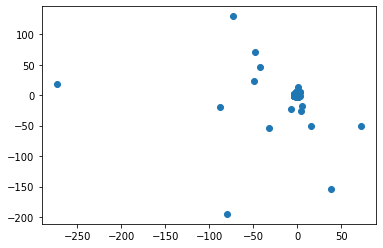

In [184]:
plt.scatter(Z[:,0 ], Z[:, 1])


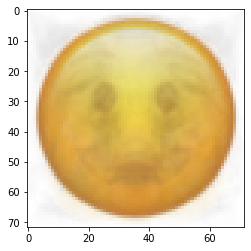

In [200]:
imshow3([50,-50])

In [198]:
modelgp.predict_log_density(np.array([[0,0]]))

ValueError: not enough values to unpack (expected 2, got 1)

In [247]:
Y.shape


(88, 20736)